# Generating tables and plots for the paper

The code in this notebook generates Tables 4 and 5, Figures 5 and 6 in our paper on [Provenance Graph Kernel](https://arxiv.org/abs/2010.10343). It is run automatically as part of the evaluation pipeline (`make plots`).

Note: The latest version of this notebook is maintained at the repo [trungdong/provenance-kernel-evaluation](https://github.com/trungdong/provenance-kernel-evaluation) on Github.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
from scripts.experiments.common import method_short_names

## Loading scoring and timing data

In [3]:
OUTPUTS_PATH = Path("outputs/")

In [4]:
def load_scoring(dataset_id) -> pd.DataFrame:
    outputs_folder = OUTPUTS_PATH / dataset_id
    output_filepath = outputs_folder / "scoring.pickled"
    
    results = pd.read_pickle(output_filepath)
    
    return results

In [5]:
# Identifiers for the six datasets
dataset_ids = ["MIMIC-PXC7", "CM-Buildings", "CM-Routes", "CM-RouteSets", "PG-T", "PG-D"]
dataset_names = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]

In [6]:
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]

In [7]:
# The following graph kernels are in the "slow" group
slow_GKs = {
    "GK-GSamp",
    "GK-NSPD",
    "GK-NH",
    "GK-SPath",
    "GK-WL-OA-1",
    "GK-WL-OA-2",
    "GK-WL-OA-3",
    "GK-WL-OA-4",
    "GK-WL-OA-5",
    "GK-OddSth",
}

group_prefixes = {
    "GK": "GK-fast",  # all other graph kernels are in the "fast" group
    "PNA": "PNA",  # Provenance Network Analytics method
    "FG": "PK-G",  # provenance kernels using generic PROV types
    "FA": "PK-A",  # provenance kernels using generic PROV types and application types
    "DG": "PK-GD",  # provenance kernels using generic PROV types with 2-length derivations
    "DA": "PK-AD",  # provenance kernels using generic PROV types and application types with 2-length derivations
    "TG": "PK-GT",  # kernels with WdfT transformations (generic PROV types)
    "TA": "PK-AT",  # kernels with WdfT transformations (generic PROV types + application types)
}

def name_group(method: str) -> str:
    if method in slow_GKs:
        return "GK-slow"
    try:
        prefix = method.split("-", 1)[0]
        return group_prefixes[prefix]
    except KeyError:
        return "AppData"

def best_performers(results: pd.DataFrame, scoring="accuracy"):
    # Give them a group name for plotting
    results = results.copy()
    # add a "group_name" column to the table
    results["group_name"] = results.method.map(name_group)

    best_methods = set()
    for group_name in ["PK-G", "PK-A", "PNA", "GK-slow", "GK-fast"]:
        group_scorings = results[results.group_name == group_name]
        if group_scorings.empty:
            continue
        best_methods.add(group_scorings.groupby("method")[scoring].mean().idxmax())

    # return a filtered table with only the best methods identified above
    return results[results.method.isin(best_methods)]


### Loading scoring of the best methods

In [8]:
scorings_to_plots = []

for dataset_id, dataset_name in zip(dataset_ids, dataset_names):
    # load the scoring data for this classification task
    df = load_scoring(dataset_id)
    df["dataset"] = dataset_name
    # only keep the scoring data of the best-performing methods in this task
    scorings_to_plots.append(best_performers(df))

scorings = pd.concat(scorings_to_plots, ignore_index=True)

## Comparing timings of the best methods in each classification task

In [9]:
summary = scorings.groupby(["dataset", "group_name", "method"]).mean()
summary

accuracy        f1    recall  precision   
dataset group_name method                                                
CM-B    GK-fast    GK-HC-2     0.897668  0.897668  0.897668   0.897668  \
        GK-slow    GK-WL-OA-3  0.902786  0.902786  0.902786   0.902786   
        PK-A       FA-0        0.900376  0.900376  0.900376   0.900376   
        PK-G       FG-2        0.900886  0.900886  0.900886   0.900886   
        PNA        PNA-DTree   0.894819  0.894819  0.894819   0.894819   
CM-R    GK-fast    GK-WL-2     0.979891  0.979891  0.979891   0.979891   
        GK-slow    GK-WL-OA-5  0.976306  0.976306  0.976306   0.976306   
        PK-A       FA-5        0.969327  0.969327  0.969327   0.969327   
        PK-G       FG-4        0.928238  0.928238  0.928238   0.928238   
        PNA        PNA-DTree   0.935216  0.935216  0.935216   0.935216   
CM-RS   GK-fast    GK-WL-3     0.949908  0.949908  0.949908   0.949908   
        GK-slow    GK-WL-OA-5  0.962091  0.962091  0.962091   0.962091   
        PK-A       FA-3        0.964783  0.964783  0.964783   0.964783   
        PK-G       FG-5        0.957628  0.957628  0.957628   0.957628   
        PNA        PNA-RF      0.939887  0.939887  0.939887   0.939887   
MIMIC   GK-fast    GK-WL-2     0.807565  0.807565  0.807565   0.807565   
        GK-slow    GK-GSamp    0.819251  0.819251  0.819251   0.819251   
        PK-A       FA-0        0.785697  0.785697  0.785697   0.785697   
        PK-G       FG-4        0.766701  0.766701  0.766701   0.766701   
        PNA        PNA-SVM     0.751659  0.751659  0.751659   0.751659   
PG-D    GK-fast    GK-WL-5     0.757500  0.757500  0.757500   0.757500   
        GK-slow    GK-SPath    0.773833  0.773833  0.773833   0.773833   
        PK-A       FA-2        0.782000  0.782000  0.782000   0.782000   
        PK-G       FG-5        0.753417  0.753417  0.753417   0.753417   
        PNA        PNA-SVM     0.712833  0.712833  0.712833   0.712833   
PG-T    GK-fast    GK-WL-5     0.706917  0.706917  0.706917   0.706917   
        GK-slow    GK-OddSth   0.718917  0.718917  0.718917   0.718917   
        PK-A       FA-3        0.852833  0.852833  0.852833   0.852833   
        PK-G       FG-3        0.694417  0.694417  0.694417   0.694417   
        PNA        PNA-DTree   0.695333  0.695333  0.695333   0.695333   

                                     time  
dataset group_name method                  
CM-B    GK-fast    GK-HC-2       0.119757  
        GK-slow    GK-WL-OA-3    5.565216  
        PK-A       FA-0          0.345222  
        PK-G       FG-2          0.154408  
        PNA        PNA-DTree    14.787004  
CM-R    GK-fast    GK-WL-2       0.399174  
        GK-slow    GK-WL-OA-5   84.633138  
        PK-A       FA-5          0.480918  
        PK-G       FG-4          0.468404  
        PNA        PNA-DTree    44.640794  
CM-RS   GK-fast    GK-WL-3       0.820036  
        GK-slow    GK-WL-OA-5  204.752158  
        PK-A       FA-3          0.864731  
        PK-G       FG-5          1.000685  
        PNA        PNA-RF       89.171987  
MIMIC   GK-fast    GK-WL-2       2.523783  
        GK-slow    GK-GSamp    480.576627  
        PK-A       FA-0          1.324241  
        PK-G       FG-4          2.199728  
        PNA        PNA-SVM     363.247364  
PG-D    GK-fast    GK-WL-5       0.570520  
        GK-slow    GK-SPath      2.948435  
        PK-A       FA-2          0.826063  
        PK-G       FG-5          1.181855  
        PNA        PNA-SVM     119.003736  
PG-T    GK-fast    GK-WL-5       0.243795  
        GK-slow    GK-OddSth     1.522390  
        PK-A       FA-3          0.281042  
        PK-G       FG-3          0.262677  
        PNA        PNA-DTree    30.447782

### Finding the time cost of the best PK method (between PK-G and PK-A)

In [10]:
best_pk_accuracy = dict()  # best accuracy between PK-G and PK-A for a classification task
best_pk_method = dict()  # achieved by which method
best_pk_time = dict()  # and its corresponding time cost

for row in summary.itertuples():
    dataset, group_name, method = row.Index

    if group_name in {"PK-G", "PK-A"}:
        to_be_updated = True
        try:
            if best_pk_accuracy[dataset] > row.accuracy:
                to_be_updated = False
        except KeyError:
            pass  # first time seeing this dataset, to reco

        if to_be_updated:
            best_pk_accuracy[dataset] = row.accuracy
            best_pk_method[dataset] = method
            best_pk_time[dataset] = row.time

### Calculating the relative time for all methods in each classification task

In [11]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    relative_time = row.time / best_pk_time[dataset]
    data.append((dataset, group_name, method, row.accuracy, relative_time))

rel_time_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Accuracy", "Relative Time"])

### Table 4
Within each dataset, we report the time cost of the best-performing method (shown in parentheses) from each comparison group relative to the time taken by the best-performing PK method (whose time cost shown as 1.0).

In [12]:
rel_time_df["time_method"] = rel_time_df.apply(
    lambda row: "%.1f (%s)" % (row[4], method_short_names[row[2]]),
    axis=1
)

In [13]:
table4 = rel_time_df.pivot(index="Dataset", columns="Group", values="time_method").reindex(dataset_names)[
    ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
]
table4

Group,PK-G,PK-A,GK-fast,GK-slow,PNA
Dataset,,,,,
MIMIC,1.7 (G4),1.0 (A0),1.9 (WL2),362.9 (GS),274.3 (SVM)
CM-B,1.0 (G2),2.2 (A0),0.8 (HC2),36.0 (WLO3),95.8 (DT)
CM-R,1.0 (G4),1.0 (A5),0.8 (WL2),176.0 (WLO5),92.8 (DT)
CM-RS,1.2 (G5),1.0 (A3),0.9 (WL3),236.8 (WLO5),103.1 (RF)
PG-T,0.9 (G3),1.0 (A3),0.9 (WL5),5.4 (ODD),108.3 (DT)
PG-D,1.4 (G5),1.0 (A2),0.7 (WL5),3.6 (SP),144.1 (SVM)


In [14]:
# Save table 4 for later
table4.to_csv("plots/table4.csv")
table4.to_html("plots/table4.html")

## Comparing the accuracy of the best PK method vs the best in the other comparison groups

In [15]:
def ranksums(df: pd.DataFrame, methods, scoring="accuracy", pvalue_significant=0.05):
    # returns None if the difference between the two methods is not statistically significant
    # according to the ranksums test; otherwise, returns the mean difference value.

    assert len(methods) == 2
    assert scoring in df.columns

    print("Wilcoxon rank-sum test:", scoring)
    print(f"> Comparing {methods[0]} vs {methods[1]}")

    p1 = df[df.method == methods[0]]
    p1.reset_index(inplace=True)
    p1_mean = p1[scoring].mean()

    p2 = df[df.method == methods[1]]
    p2.reset_index(inplace=True)
    p2_mean = p2[scoring].mean()

    mean_diff = p1_mean - p2_mean
    _, pvalue = stats.ranksums(p1[scoring], p2[scoring])
    if pvalue > pvalue_significant:
        print(f"> Insignificant (pvalue = {pvalue * 100:.1f}%)")
        return None
    else:
        print(f"> *Significant* (pvalue = {pvalue * 100:.1f}%)")
        print(f"> Mean difference: {mean_diff * 100:+.1f}%")
        return mean_diff

In [16]:
def mean_diff_value_display(mean_diff, min_diff=0.02):
    if mean_diff is None:
        return "="

    # mean_diff is not None
    if abs(mean_diff) >= min_diff:
        return f"{mean_diff * 100:.0f}%"
    else:
        return "="

### Table 5

Summary of the accuracy differences between the best-performing PK-based method and the best-performing method in the GK-slow, GK-fast, and PNA groups. An “=” sign means the accuracy difference is not statistically significant according to the Wilcoxson Rank Sum test (also known as Mann Whitney U Test); while a positive/negative value shows how much the PK-based method outperforms/under-performs the corresponding GK/PNA method, respectively, when the difference is statistically significant.

In [17]:
def rank_against(selected_groups, scoring="accuracy", min_diff=0.02):
    # Looking for the best method in the select groups for each dataset
    # calculate their mean scoring
    df = scorings[scorings.group_name.isin(selected_groups)].groupby(["dataset", "method"]).mean(numeric_only=True)
    # find the method with the highest mean scoring value for each dataset
    best_method = {
        dataset: group.set_index("method")[scoring].idxmax()
        for dataset, group in df.reset_index().groupby("dataset")
    }

    data = []
    for row in summary.itertuples():
        dataset, group_name, method = row.Index
        if method != best_method[dataset]:
            print(f"[ {dataset}: comparing {best_method[dataset]} against {method} ]")
            mean_diff = ranksums(scorings[scorings.dataset == dataset], [best_method[dataset], method])
            # ignoring difference less than min_diff
            cell_value = mean_diff_value_display(mean_diff, min_diff)
        else:
            cell_value = f"[{method_short_names.get(method, method)}]"
        data.append((dataset, group_name, method, cell_value))

    comp_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Diff"])
    return comp_df

In [18]:
comparison_df = rank_against({"PK-A", "PK-D"}, min_diff=0.02)

[ CM-B: comparing FA-0 against GK-HC-2 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs GK-HC-2
> Insignificant (pvalue = 31.9%)
[ CM-B: comparing FA-0 against GK-WL-OA-3 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs GK-WL-OA-3
> Insignificant (pvalue = 44.3%)
[ CM-B: comparing FA-0 against FG-2 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs FG-2
> Insignificant (pvalue = 86.8%)
[ CM-B: comparing FA-0 against PNA-DTree ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-0 vs PNA-DTree
> Insignificant (pvalue = 8.5%)
[ CM-R: comparing FA-5 against GK-WL-2 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-2
> *Significant* (pvalue = 0.0%)
> Mean difference: -1.1%
[ CM-R: comparing FA-5 against GK-WL-OA-5 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs GK-WL-OA-5
> *Significant* (pvalue = 0.0%)
> Mean difference: -0.7%
[ CM-R: comparing FA-5 against FG-4 ]
Wilcoxon rank-sum test: accuracy
> Comparing FA-5 vs FG-4
> *Significant* (pvalue = 0.0%)
> Mea

In [19]:
table5 = comparison_df.pivot(index="Group", columns="Dataset", values="Diff").reindex(["GK-slow", "GK-fast", "PNA"])[dataset_names]
table5

Dataset,MIMIC,CM-B,CM-R,CM-RS,PG-T,PG-D
Group,,,,,,
GK-slow,-3%,=,=,=,13%,=
GK-fast,-2%,=,=,=,15%,2%
PNA,3%,=,3%,2%,16%,7%


In [20]:
# Save Table 5 for later
table5.to_csv("plots/table5.csv")
table5.to_html("plots/table5.html")

## Generating plots

In [21]:
# store the current colour palette
current_palette = sns.color_palette()

### Figure 5: The relative time costs of the best-performing methods reported in Table 4 plotted on the log scale

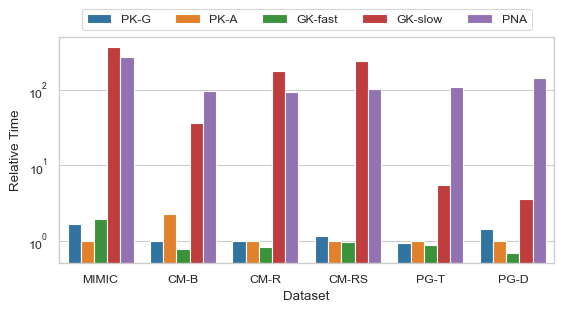

In [22]:
dataset_order = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]
selected_groups = ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
plot = sns.barplot(x="Dataset", y="Relative Time", hue="Group", order=dataset_order, hue_order=selected_groups, data=rel_time_df)
plot.set_yscale("log")
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plot.figure.set_size_inches(5.75, 3.25)
plt.tight_layout()

In [23]:
# saving the above plot
plot.figure.savefig("plots/best-performers-relative-timing.pdf")

### Figure 6: The mean classification accuracy of the best-performing provenance kernels, generic graph kernels, and PNA methods across the six classification tasks. The error bars show the 95-percent confidence intervals

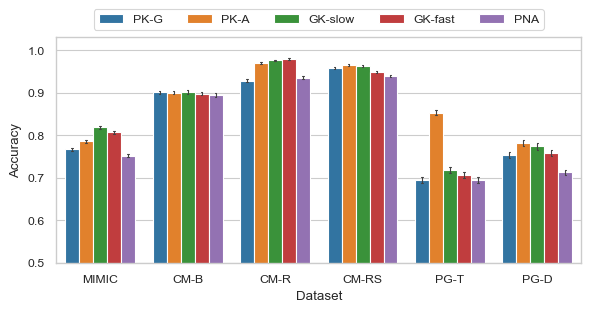

In [24]:
plt.figure()
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]
df = scorings[scorings.group_name.isin(set(selected_groups))]
plot = sns.barplot(x="dataset", y="accuracy", hue="group_name",
                   hue_order=selected_groups, data=df, palette=current_palette,
                   errwidth=0.8, capsize=0.02)
plot.set(xlabel="Dataset", ylabel="Accuracy")
plot.figure.set_size_inches(6, 3.25)
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plt.ylim(0.5)
plt.tight_layout()

In [25]:
plot.figure.savefig("plots/accuracy-best-performers.pdf")